In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

faces = pd.read_csv('data/FGNet-LOPO.csv')


In [2]:
faces['ageclass'] = faces.age.apply(
    lambda r: 0 if r < 17 else 1
).astype(int)
faces.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,b104,b105,b106,b107,b108,b109,age,ID,Gender_0M_1F,ageclass
0,0.585770,-0.075982,-0.276594,0.076490,0.189404,-0.152451,0.003264,-0.366677,0.148862,-0.078316,...,0.012785,0.014379,-0.032976,-0.005910,0.015997,-0.002833,5,1,0,0
1,0.117512,-0.344377,0.413923,-0.088210,0.152117,-0.020675,-0.085257,-0.122578,0.085524,-0.035403,...,0.006724,0.014217,0.001321,-0.005616,-0.018197,-0.000073,8,1,0,0
2,0.248636,-0.209122,0.516829,-0.124100,-0.002087,0.165375,-0.033023,0.035212,0.156937,-0.028065,...,0.023377,0.028616,-0.009582,-0.020722,0.003676,-0.015716,10,1,0,0
3,0.136742,-0.095098,0.428192,-0.125278,-0.117103,0.080187,0.109120,-0.068001,0.185257,-0.001298,...,0.021750,0.006348,-0.006021,-0.005336,0.002317,-0.014843,14,1,0,0
4,-0.371003,-0.164112,0.431468,-0.163736,-0.217533,0.083152,-0.053181,-0.169808,0.178207,-0.000211,...,0.008738,0.002282,-0.021130,-0.009988,-0.016178,-0.003646,16,1,0,0


In [3]:
x = faces.drop(["age", "ID", "Gender_0M_1F"], axis = 1)
y = faces[["age", "ID", "Gender_0M_1F", "ageclass"]]
y_young = y[y.ageclass == 0]
y_old = y[y.ageclass == 1]
x_young = x[x.ageclass == 0].drop(["ageclass"], axis = 1)
x_old = x[x.ageclass == 1].drop(["ageclass"], axis = 1)
x = x.drop(["ageclass"], axis = 1)
x_young_train, x_young_test, y_young_train, y_young_test = train_test_split(x_young, y_young, test_size = .2)
x_old_train, x_old_test, y_old_train, y_old_test = train_test_split(x_old, y_old, test_size = .2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)


In [185]:
lis = []

for x in range(1):
    x = faces.drop(["age", "ID", "Gender_0M_1F"], axis = 1)
    y = faces[["age", "ID", "Gender_0M_1F", "ageclass"]]
    y_young = y[y.ageclass == 0]
    y_old = y[y.ageclass == 1]
    x_young = x[x.ageclass == 0].drop(["ageclass"], axis = 1)
    x_old = x[x.ageclass == 1].drop(["ageclass"], axis = 1)
    x = x.drop(["ageclass"], axis = 1)
    x_young_train, x_young_test, y_young_train, y_young_test = train_test_split(x_young, y_young, test_size = .2, random_state = 2)
    x_old_train, x_old_test, y_old_train, y_old_test = train_test_split(x_old, y_old, test_size = .2, random_state = 2)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 2)
    logReg = LogisticRegression(solver= 'liblinear').fit(x_train, y_train["ageclass"])
    boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=2).fit(x_train, y_train["ageclass"])
    svm = SVC(C=1000, gamma = .01, kernel='rbf', random_state=2).fit(x_train, y_train["ageclass"])
    forest = RandomForestClassifier(max_depth=2, random_state=2).fit(x_train, y_train["ageclass"])
    reg = Ridge(alpha=.1).fit(x_young_train, y_young_train["age"])
    #reg = make_pipeline(StandardScaler(), LinearSVR(random_state = 2, epsilon=2.97, tol=1e-6, C=20)).fit(x_young_train, y_young_train["age"])
    #regTwo = Ridge(alpha=.05).fit(x_old_train, y_old_train["age"])
    regTwo = make_pipeline(StandardScaler(), LinearSVR(random_state = 2, epsilon=2.97, tol=1e-6, C=14.1)).fit(x_old_train, y_old_train["age"])
    mae = {}
    errors = []

    for model in [svm]:
        score = 0
        total = 0
        error = 0
        for index, row in x_test.iterrows():
            row = row.values.reshape(1,-1)
            if model.predict(row) == 0:
                age = reg.predict(row)
                if np.round(age) == y_test["age"][index]:
                    score += 1
                error += abs(y_test["age"][index] - age)
                total += 1
            else:
                age = regTwo.predict(row)
                if np.round(age) == y_test["age"][index]:
                    score += 1
                error += abs(y_test["age"][index] - age)
                total += 1

    print(error/total)
    lis.append(float(error/total))
    
lis.append(np.mean(lis))
print(np.mean(lis))

[2.99502488]
2.9950248756218905


/Users/abc/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [137]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression

regr = make_pipeline(StandardScaler(), LinearSVR(random_state = 2, epsilon=2, tol=1e-5, C=14.1)).fit(x_old_train, y_old_train["age"])
for model in [regr]:
    total = 0
    error = 0
    for index, row in x_old_test.iterrows():
        row = row.values.reshape(1,-1)
        total += 1
        error += abs(y_old_test["age"][index] - np.round(model.predict(row)))
    print(error/total)    


/Users/abc/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[6.84615385]


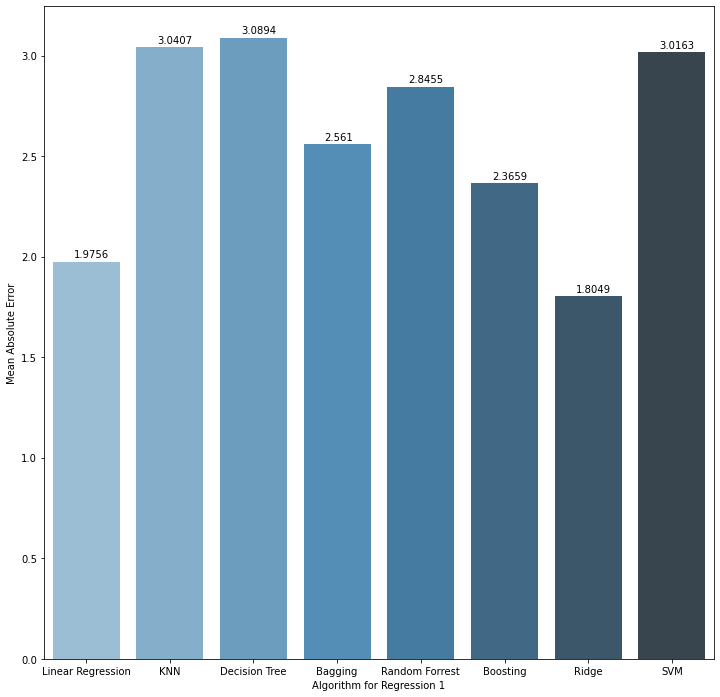

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression

linReg = LinearRegression().fit(x_young_train, y_young_train["age"])
KNN = KNeighborsRegressor(n_neighbors=2).fit(x_young_train, y_young_train["age"])
tree = DecisionTreeRegressor(max_depth=5).fit(x_young_train, y_young_train["age"])
bag = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=2).fit(x_young_train, y_young_train["age"])
randFor = RandomForestRegressor(max_depth=2, random_state=2).fit(x_young_train, y_young_train["age"])
boost = GradientBoostingRegressor(random_state=2).fit(x_young_train, y_young_train["age"])
ridge = Ridge(alpha=.5).fit(x_young_train, y_young_train["age"])
svm = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.2)).fit(x_young_train, y_young_train["age"])

errors = []
maeOne = {}
total = 0
error = 0
    
for model in [linReg, KNN, tree, bag, randFor, boost, ridge, svm]:
    total = 0
    error = 0
    for index, row in x_young_test.iterrows():
        row = row.values.reshape(1,-1)
        total += 1
        error += abs(y_young_test["age"][index] - np.round(model.predict(row)))
    errors.append(error/total)
    
modelNames = ["Linear Regression", "KNN", "Decision Tree", "Bagging", "Random Forrest", "Boosting", "Ridge", "SVM"]
for index in range(8):
    maeOne[modelNames[index]] = float(errors[index])
    
import seaborn as sns
plt.subplots(figsize = (12,12))
ax = sns.barplot(x = modelNames, y = list(maeOne.values()), palette="Blues_d") 
plt.xlabel('Algorithm for Regression 1')
plt.ylabel('Mean Absolute Error')
for index, value in enumerate(list(maeOne.values())):
    plt.text(index-.15, value+.02,
             str(round(value, ndigits = 4)))
    
plt.savefig('SVSM Regressor 1 Hybrid')

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
grid = GridSearchCV(Ridge(random_state=2), param_grid, refit = True, verbose = 3)
grid.fit(x_young_train, y_young_train["age"])

print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
boost = GradientBoostingRegressor(random_state=2).fit(x_young_train, y_young_train["age"])

In [ ]:
bag = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=2).fit(x_young_train, y_young_train["age"])

In [ ]:
linReg = LinearRegression().fit(x_young_train, y_young_train["age"])

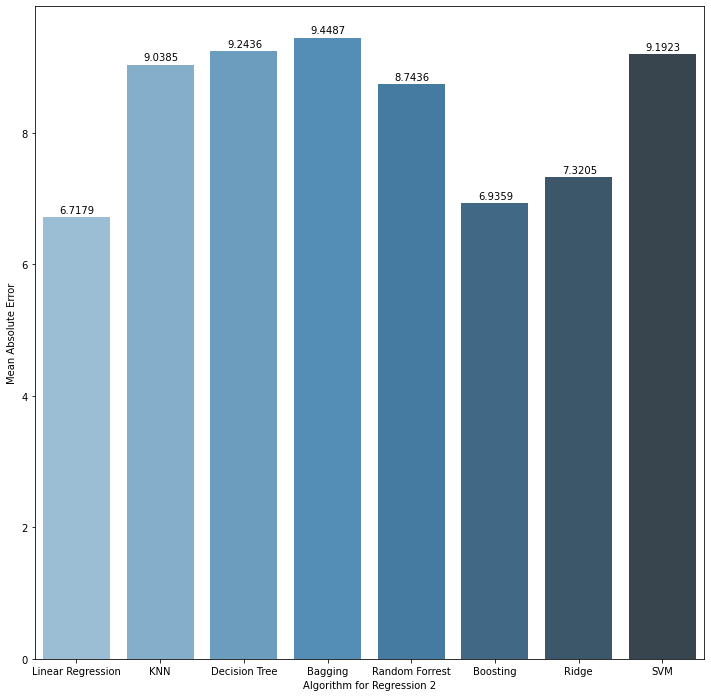

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linReg = LinearRegression().fit(x_old_train, y_old_train["age"])
KNN = KNeighborsRegressor(n_neighbors=2).fit(x_old_train, y_old_train["age"])
tree = DecisionTreeRegressor(max_depth=5).fit(x_old_train, y_old_train["age"])
bag = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=2).fit(x_old_train, y_old_train["age"])
randFor = RandomForestRegressor(max_depth=2, random_state=2).fit(x_old_train, y_old_train["age"])
boost = GradientBoostingRegressor(random_state=2).fit(x_old_train, y_old_train["age"])
ridge = Ridge(alpha=1.0).fit(x_old_train, y_old_train["age"])
svm = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)).fit(x_old_train, y_old_train["age"])

errors = []
maeOne = {}
total = 0
error = 0
    
for model in [linReg, KNN, tree, bag, randFor, boost, ridge, svm]:
    total = 0
    error = 0
    for index, row in x_old_test.iterrows():
        row = row.values.reshape(1,-1)
        total += 1
        error += abs(y_old_test["age"][index] - np.round(model.predict(row)))
    errors.append(error/total)
    
modelNames = ["Linear Regression", "KNN", "Decision Tree", "Bagging", "Random Forrest", "Boosting", "Ridge", "SVM"]
for index in range(8):
    maeOne[modelNames[index]] = float(errors[index])
    
import seaborn as sns
plt.subplots(figsize = (12,12))
ax = sns.barplot(x = ["Linear Regression", "KNN", "Decision Tree", "Bagging", "Random Forrest", "Boosting", "Ridge", "SVM"], y = list(maeOne.values()), palette="Blues_d") 
plt.xlabel('Algorithm for Regression 2')
plt.ylabel('Mean Absolute Error')
for index, value in enumerate(list(maeOne.values())):
    plt.text(index-.2, value+.06,
             str(round(value, ndigits = 4)))
    
plt.savefig('SVSM Regressor 2 Hybrid')

[2.736318407960199, 3.5621890547263684, 3.7860696517412937, 3.512437810945274, 3.63681592039801, 3.36318407960199, 3.383084577114428, 3.9502487562189055, 3.6218905472636815, 3.800995024875622, 3.5353233830845765]


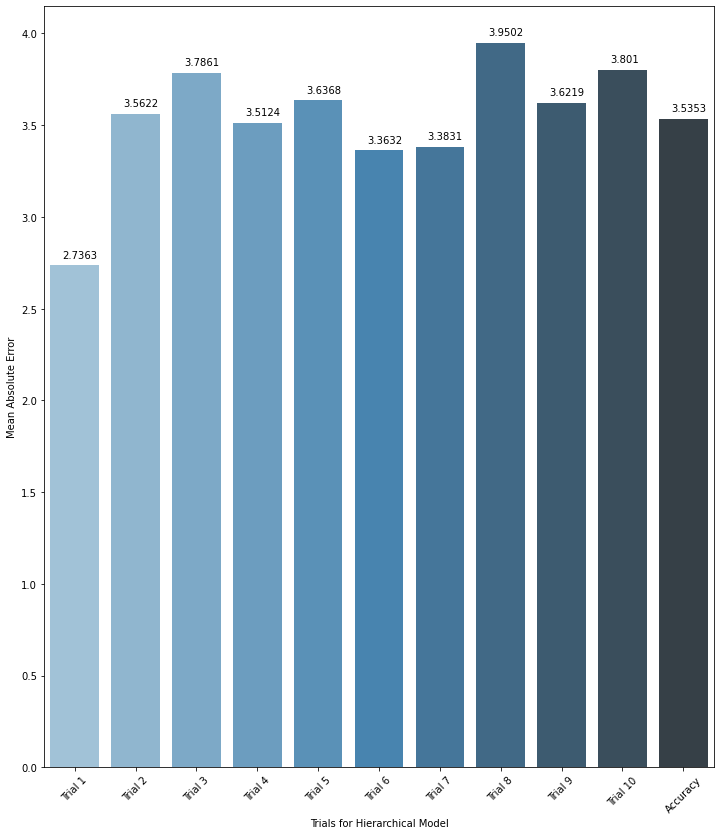

In [10]:
import seaborn as sns
print(lis)
plt.subplots(figsize = (12,14))
ax = sns.barplot(x = ["Trial 1", "Trial 2", "Trial 3", "Trial 4", "Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10", "Accuracy"], y = list(lis), palette="Blues_d") 
plt.xlabel('Trials for Hierarchical Model')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

for index, value in enumerate(list(lis)):
    plt.text(index-.2, value+.04,
             str(round(value, ndigits = 4)))